# CW1 - Object Recognition using CNN
To apply machine learning alorithms to clasify the testing images into object categories. Then use a model to perform classification and report quantitative results.

Due: Monday 19th April

# Introduction

The aim is to evaluate the use of CNN's in image recognition and the affect of adding multiple layers.

# Imports 

In [1]:
import numpy as np
from numpy import load
from numpy import asarray
from numpy import save
import matplotlib.pyplot as plt
import tensorflow as tf
import skimage.feature
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Load Data
There are 100 different categories of objects
each has 500 images for training and 100 images for testing.
Split the data into train and test sections

In [2]:
images = np.load('trnImage.npy')
label_fine = np.load('trnLabel_fine.npy')
label_coarse = np.load('trnLabel_coarse.npy')

#image_index = 1 # pick a specific image
#image = images[:, :, :, image_index]

test_images = np.load('tstImage.npy')
test_label_fine = np.load('tstLabel_fine.npy')
test_label_coarse = np.load('tstLabel_coarse.npy')

print(f'Images Shape: {images.shape}')
print(f'Train Labels Fine Shape: {label_fine.shape}')
print(f'Train Labels Coarse Shape: {label_coarse.shape}')

Images Shape: (32, 32, 3, 50000)
Train Labels Fine Shape: (50000,)
Train Labels Coarse Shape: (50000,)


## Shuffle data to ensure not ordered

In [3]:
images = shuffle(images, random_state=0)
label_fine, label_coarse = shuffle(label_fine, label_coarse, random_state=0) #make sure the samples are not ordered


test_images = shuffle(test_images, random_state=0)
test_label_fine, test_label_coarse = shuffle(test_label_fine, test_label_coarse, random_state=0)

# CNN

## Normalise the data, for each image do a hog, add how to array, train images

In [4]:
try:
    train_images_normalised = load('hog_array_train.npy')
    print(train_images_normalised.shape)
except FileNotFoundError: 
    
    train_images_normalised = []
    
    for image_index in range(0, images.shape[3]):
        print(image_index, images.shape[3])
        image = images[:, :, :, image_index]

        # Extract features from a single image
        _, hog_image = skimage.feature.hog(image, pixels_per_cell=[2,2], cells_per_block=[3,3], visualize=True)
        train_images_normalised.append(hog_image)
        
    train_images_output = np.array(train_images_normalised)
    data = asarray(train_images_output)
        # save to npy file
    save('hog_array_train.npy', data)
    

(50000, 32, 32)


In [5]:
try:
    test_images_normalised = load('hog_array_test.npy')
    print(test_images_normalised.shape)
    
except: 
    test_images_normalised = []
    for image_index in range(0, test_images.shape[3]):
        print(image_index, test_images.shape[3])
        image = test_images[:, :, :, image_index]

        # Extract features from a single image
        _, hog_image = skimage.feature.hog(image, pixels_per_cell=[2,2], cells_per_block=[3,3], visualize=True)
        test_images_normalised.append(hog_image)

    train_images_output = np.array(test_images_normalised)
    data = asarray(train_images_output)
    save('hog_array_test.npy', data)

(10000, 32, 32)


## Check the Data cardinality

In [6]:
train_images_reshaped = train_images_normalised.reshape(50000, 32, 32, 1)
test_images_reshaped = test_images_normalised.reshape(10000, 32, 32, 1)

print("train shape " + str(train_images_reshaped.shape))
print("test shape " + str(test_images_reshaped.shape) + "\n")

print("coarse shape " + str(label_coarse.shape))
print("fine shape " + str(label_fine.shape)+ "\n")

output_num_fine = (np.unique(label_fine).shape[0])
print("Unique Fine labels " + str(output_num_fine))

output_num_coarse = (np.unique(label_coarse).shape[0])
print("unique Coarse Labels " + str(output_num_coarse))


train shape (50000, 32, 32, 1)
test shape (10000, 32, 32, 1)

coarse shape (50000,)
fine shape (50000,)

Unique Fine labels 100
unique Coarse Labels 20


## Split Training data into a train and test split

In [7]:
xTrn_split, xTst_split, yTrn_split, yTst_split = train_test_split(train_images_reshaped, label_coarse, test_size=0.2)

## Create a Tensorflow Convolutional Neural Network on the training set using Conv2D and pooling Layers

In [20]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='selu', input_shape=(32, 32, 1)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
Total params: 9,568
Trainable params: 9,568
Non-trainable params: 0
_________________________________________________________________


## Train and fit the model

softmax - sed as the last activation function of a neural network to normalize the output of a network

In [21]:
model.add(tf.keras.layers.Flatten()) #dense layers can oinly have 1d so flattern araray to one dimension
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='selu'))
model.add(tf.keras.layers.Dense(output_num_coarse, activation='softmax'))

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
history = model.fit(xTrn_split, yTrn_split, epochs=100, 
                    validation_data=(xTst_split, yTst_split))

Epoch 1/100
1250/1250 [==============================] - 11s 9ms/step - loss: 3.0002 - accuracy: 0.0515 - val_loss: 2.9965 - val_accuracy: 0.0475
Epoch 2/100
1250/1250 [==============================] - 10s 8ms/step - loss: 2.9972 - accuracy: 0.0473 - val_loss: 2.9980 - val_accuracy: 0.0494
Epoch 3/100
1250/1250 [==============================] - 11s 8ms/step - loss: 2.9968 - accuracy: 0.0513 - val_loss: 2.9980 - val_accuracy: 0.0528
Epoch 4/100
1250/1250 [==============================] - 11s 9ms/step - loss: 2.9970 - accuracy: 0.0483 - val_loss: 2.9979 - val_accuracy: 0.0484
Epoch 5/100
1250/1250 [==============================] - 11s 8ms/step - loss: 2.9960 - accuracy: 0.0513 - val_loss: 2.9965 - val_accuracy: 0.0486
Epoch 6/100
1250/1250 [==============================] - 11s 8ms/step - loss: 2.9948 - accuracy: 0.0530 - val_loss: 3.0020 - val_accuracy: 0.0512
Epoch 7/100
1250/1250 [==============================] - 10s 8ms/step - loss: 2.9926 - accuracy: 0.0553 - val_loss: 3.0075 -

Epoch 57/100
1250/1250 [==============================] - 11s 9ms/step - loss: 1.6774 - accuracy: 0.4592 - val_loss: 6.4814 - val_accuracy: 0.0497
Epoch 58/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.6671 - accuracy: 0.4646 - val_loss: 6.8221 - val_accuracy: 0.0497
Epoch 59/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.6535 - accuracy: 0.4701 - val_loss: 6.9301 - val_accuracy: 0.0494
Epoch 60/100
1250/1250 [==============================] - 11s 8ms/step - loss: 1.6531 - accuracy: 0.4625 - val_loss: 6.9244 - val_accuracy: 0.0486
Epoch 61/100
1250/1250 [==============================] - 11s 8ms/step - loss: 1.6352 - accuracy: 0.4726 - val_loss: 7.2241 - val_accuracy: 0.0489
Epoch 62/100
1250/1250 [==============================] - 11s 8ms/step - loss: 1.6355 - accuracy: 0.4685 - val_loss: 6.8408 - val_accuracy: 0.0513
Epoch 63/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.6268 - accuracy: 0.4785 - val_loss: 7

##  Predict labels for the testing set and check accuracy

In [23]:
print(model.predict(test_images_reshaped))

[[3.7208243e-05 1.3156892e-04 8.4406354e-02 ... 3.7541618e-03
  6.8277662e-04 3.7798347e-06]
 [2.9059731e-05 1.1924543e-05 2.9391385e-06 ... 9.7554401e-03
  3.2838815e-04 2.8069595e-02]
 [3.4600250e-02 1.7566413e-03 2.7504620e-01 ... 1.3324437e-01
  4.5037097e-03 1.9794952e-03]
 ...
 [6.2927839e-08 4.5048827e-04 1.7672627e-04 ... 2.4777933e-04
  4.0938912e-06 3.4276911e-07]
 [2.8218193e-02 7.2773695e-02 2.4289082e-01 ... 2.6041090e-01
  1.3819711e-02 1.8909350e-02]
 [3.2735559e-10 9.5278481e-14 1.7691275e-09 ... 6.7903623e-14
  7.1002150e-06 2.7496187e-08]]


## Plot models traing curves 

313/313 - 1s - loss: 10.9378 - accuracy: 0.0525
0.05249999836087227


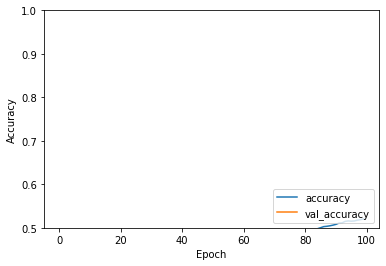

In [24]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images_reshaped,  test_label_coarse, verbose=2)

print(test_acc)

In [25]:
score = model.evaluate(test_images_reshaped, test_label_coarse, verbose=0)
print(score)

[10.937837600708008, 0.05249999836087227]
